In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from statsmodels.stats.stattools import durbin_watson
from sklearn.metrics import r2_score
RND_STATE = 344
%matplotlib inline

## 1. Загрузка данных

In [2]:
data = pd.read_csv('data/hotel_data.csv', sep=';')

In [3]:
data.head()

,Hotel name,Rating,Stars,Distance to the sea,Distance to the downtown,Room area,Swimming pool,Price
0,Bonanova Park,7.7,2.0,7.0,5.0,16.0,0,63
1,Travelodge Barcelona Poblenou,7.9,1.0,0.5,2.0,15.0,0,83
2,Senator Barcelona Spa Hotel,7.8,4.0,5.0,3.0,21.0,1,91
3,Hotel Medicis,7.9,2.0,2.0,1.0,10.0,0,87
4,Paral-lel,8.4,2.0,0.5,1.0,19.0,0,102


### 1.1 Описание данных

In [4]:
data.describe()

,Rating,Stars,Distance to the sea,Distance to the downtown,Room area,Swimming pool,Price
count,208.000000,207.000000,208.000000,208.000000,207.000000,208.000000,208.000000
mean,7.980288,3.260870,2.585096,1.258173,18.483092,0.250000,129.754808
std,0.491125,0.841615,1.656875,1.168520,5.172599,0.434057,29.895025
min,6.400000,1.000000,0.000000,0.000000,8.000000,0.000000,63.000000
25%,7.700000,3.000000,1.500000,0.500000,15.000000,0.000000,107.000000
50%,8.000000,3.000000,2.500000,1.000000,18.000000,0.000000,126.000000
75%,8.300000,4.000000,3.000000,2.000000,21.000000,0.250000,151.250000
max,9.000000,4.000000,9.000000,5.000000,44.000000,1.000000,210.000000


Также посмотрим на медианы

In [5]:
data.median()

Rating                        8.0
Stars                         3.0
Distance to the sea           2.5
Distance to the downtown      1.0
Room area                    18.0
Swimming pool                 0.0
Price                       126.0
dtype: float64

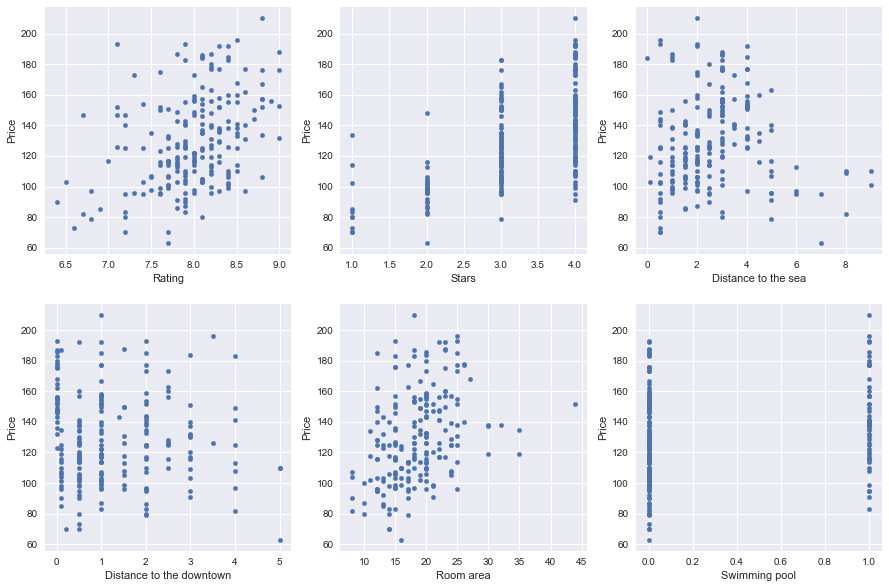

In [6]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))
for idx, feature in enumerate(data.columns[1:-1]):
    data.plot(feature, 'Price', subplots=True, kind='scatter', ax=axes[int(idx / 3), int(idx % 3)])

### 1.2 Проверка наличия пропусков

In [7]:
def checkNANs(dataframe):
    print("Есть ли пропуски в датафрейме?: ", dataframe.isnull().values.any())

In [8]:
checkNANs(data)

Есть ли пропуски в датафрейме?:  True


Найдем пропуски:

In [9]:
nan_indexes = data.isnull().any(axis=1)
data[nan_indexes]

,Hotel name,Rating,Stars,Distance to the sea,Distance to the downtown,Room area,Swimming pool,Price
6,Hotel Barbara,6.6,1.0,0.5,0.5,NaN,0,73
58,Holiday Inn Express Barcelona City 22,7.6,NaN,0.5,1.5,25.0,0,96


### 1.3 Заполнение пропусков

In [10]:
mean_dict = data.mean() # cacl mean
for key in mean_dict.keys(): # round values
    mean_dict[key] = int(mean_dict[key])

Округленные средние значения

In [11]:
mean_dict

Rating                        7.0
Stars                         3.0
Distance to the sea           2.0
Distance to the downtown      1.0
Room area                    18.0
Swimming pool                 0.0
Price                       129.0
dtype: float64

Заполняем средними

In [12]:
data = data.fillna(mean_dict)

Проверим заполнение пропусков средним значением:

In [13]:
data[nan_indexes]

,Hotel name,Rating,Stars,Distance to the sea,Distance to the downtown,Room area,Swimming pool,Price
6,Hotel Barbara,6.6,1.0,0.5,0.5,18.0,0,73
58,Holiday Inn Express Barcelona City 22,7.6,3.0,0.5,1.5,25.0,0,96


In [14]:
checkNANs(data)

Есть ли пропуски в датафрейме?:  False


## 2. Проверка данных

### 2.1 Построение корреляционной матрицы

In [15]:
data.corr()

,Rating,Stars,Distance to the sea,Distance to the downtown,Room area,Swimming pool,Price
Rating,1.000000,0.186994,-0.021557,-0.128974,0.191710,0.202255,0.405103
Stars,0.186994,1.000000,0.163200,0.177517,0.467148,0.298196,0.593109
Distance to the sea,-0.021557,0.163200,1.000000,0.333458,0.073053,0.054242,0.004539
Distance to the downtown,-0.128974,0.177517,0.333458,1.000000,0.147002,0.158823,-0.109614
Room area,0.191710,0.467148,0.073053,0.147002,1.000000,0.265290,0.362466
Swimming pool,0.202255,0.298196,0.054242,0.158823,0.265290,1.000000,0.253810
Price,0.405103,0.593109,0.004539,-0.109614,0.362466,0.253810,1.000000


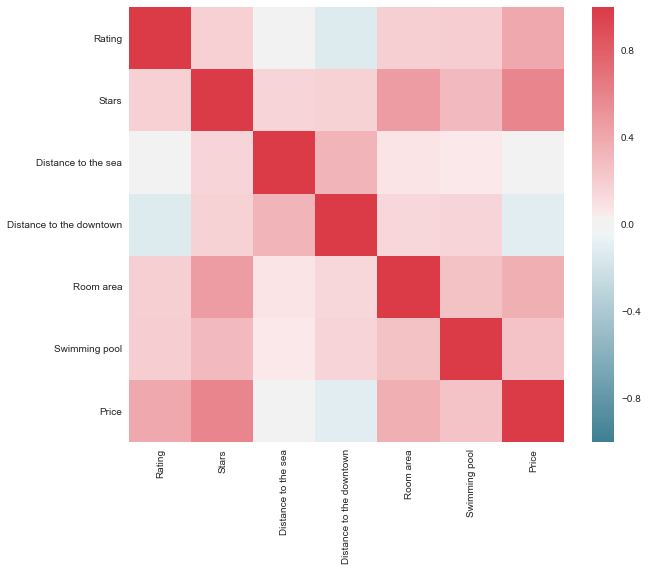

In [16]:
f, ax = plt.subplots(figsize=(10, 8))
corr = data.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

### 2.2 Удаление малоинформативных признаков

Как видно из корреляционной матрицы, зависимость между ценой и расстоянием до моря/центра города очень слабая (меньше 20%). <br>Поэтому, удалим эти признаки. 

In [17]:
data = data.drop(['Distance to the sea', 'Distance to the downtown'], axis = 1)

## 3. Предобработка данных

### 3.1 Масштабирование признаков

In [24]:
data.ix[:,1:-1].values

array([  7.7,   2. ,  16. ,   0. ])

In [28]:
scaler = StandardScaler()
X = scaler.fit_transform(data.ix[:,1:-1])
X = sm.add_constant(X)
y = data.ix[:,-1:].values.flatten()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=RND_STATE)

## 4. Обучение модели

### 4.1 Обучение МНК

In [29]:
model = sm.OLS(y_train, X_train)
results = model.fit()

In [30]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.458
Model:                            OLS   Adj. R-squared:                  0.441
Method:                 Least Squares   F-statistic:                     28.26
Date:                Sat, 13 May 2017   Prob (F-statistic):           5.03e-17
Time:                        22:02:47   Log-Likelihood:                -624.59
No. Observations:                 139   AIC:                             1259.
Df Residuals:                     134   BIC:                             1274.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const        127.2424      1.879     67.707      0.000       123.526   130.959
x1            10.9908      1.980      5.550      0.000         7.074    14.907
x2            12.2585      2.258      5.429      0.000         7.792    16.725
x3             1.7348      2.361      0.735      0.464        -2.936     6.405
x4             1.7962      2.038      0.881      0.380        -2.235     5.827
==============================================================================
Omnibus:                        3.977   Durbin-Watson:                   1.635
Prob(Omnibus):                  0.137   Jarque-Bera (JB):                3.781
Skew:                           0.344   Prob(JB):                        0.151
Kurtosis:                       2.578   Cond. No.                         2.02
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### 4.2 Оценка качества

In [21]:
y_pred = model.predict(X_test)
r2_score(y_test, y_pred)  

ValueError: shapes (139,5) and (69,5) not aligned: 5 (dim 1) != 69 (dim 0)

In [ ]:
y_test.shape

In [ ]:
t = np.linspace(0, 10, 100)
np.column_stack((t, t**2))[9]